## Notebook to test different test

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import jax.scipy as jscipy
import optimization_SPDC as opt
import get_initialization_cond as init
import scipy
import numpy as np
import time_uncouple_dynamics as uncoupling

In [2]:
# Initialize waveguide parameters
vp = 0.1
l = 1
wi = -10
wf = 10
# negative Np wuch that gamma is purely imaginary
Np = -0.1+0*1.j
N = 401
method = "hermite"
gauss_amp = 1
gauss_width = 0.4
gauss_phase = 0

In [3]:
# Get initial pump and SU(1,1) algebra elements
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, N = N)
pump = init.get_initialization_array([0, gauss_amp, gauss_width, gauss_phase], vp, l, wi, wf, Np, method = method, N=N)

In [4]:
U_ss, U_si, U_is, U_ii = opt.get_submatrices(pump, N, alpha, G, H, l)
V, W = uncoupling.get_V_W_matrices(pump, N, alpha, G, H, l)

In [5]:
# Eigenvalues and eigenvectors
eigenvalues, eigenvectors = jnp.linalg.eig(U_si@U_si.conj().T)
norm_eig = np.abs(eigenvalues*eigenvalues.conj())

In [6]:
# Get free propagation V and W
pump_free = init.get_initialization_array([0, 0, gauss_width, gauss_phase], vp, l, wi, wf, Np, method = method, N=N)
free_U_ss, free_U_si, free_U_is, free_U_ii = opt.get_submatrices(pump_free, N, alpha, G, H, l)
free_V, free_W = uncoupling.get_V_W_matrices(pump_free, N, alpha, G, H, l)

In [8]:
F = scipy.fft.fft(np.eye(N))
F_inv = scipy.fft.ifft(np.eye(N))

In [12]:
pump_matrix = opt.moving_window(pump, N)[:-1]
time_pump = scipy.fft.fftshift(jnp.diag(F@(opt.moving_window(pump, N)[:-1])@F/N))

In [20]:
supposed_V = free_V@np.diag(time_pump)@V

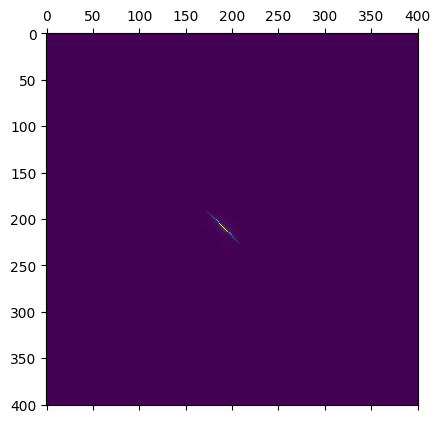

In [23]:
plt.matshow(np.abs(supposed_V))

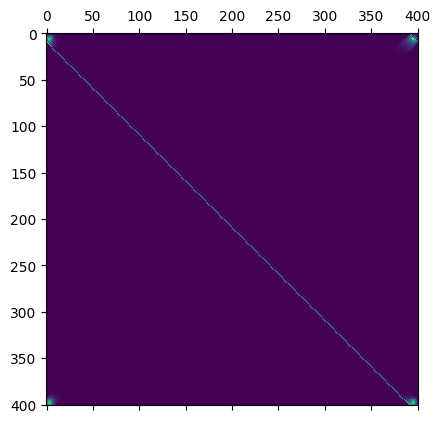

In [15]:
plt.matshow(np.abs(V))

# Code useful for pytest

In [4]:
# Build submatrices of U
K = alpha*opt.moving_window(pump, N)[:-1]
Q = jnp.block([[G, K], [-jnp.conj(K).T, -jnp.conj(H).T]])
U = jax.scipy.linalg.expm(1j*Q*l)
N = len(U)
U_ss = U[:N//2, :N//2]
U_is = U[:N//2, N//2:N]
U_si = U[N//2:N, :N//2]
U_ii = U[N//2:N,N//2:N]

In [11]:
test = F@K@F/401
a = jnp.diag(test)


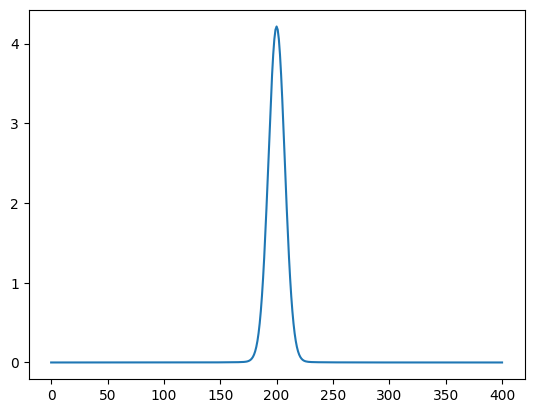

In [12]:
plt.plot(np.abs(scipy.fft.fftshift(a)))

In [5]:
# Tests to see if matrices are well built
test_phase_match_cond = jnp.allclose(G, -H)
V_matrix_verif = jnp.allclose(U_ss + U_si, U_is + U_ii, rtol=0.01)
W_matrix_verif = jnp.allclose(U_ss - U_si, U_ii - U_is, rtol=0.01)
# Commutation tests (sum is used because even though the difference is small, allclose still does not recognize them as similar matrices...)
# The absolute value of these matrices can even be plotted with matshow and it would show mostly noise
# matrix exponential can introduce a lot of noise because of the algorithm of powers used
commutation_ai_as = sum(sum(jnp.abs((U_ss@jnp.conj(U_si).T- U_is@jnp.conj(U_ii).T))))
commutation_as_as_dagger = sum(sum(jnp.abs((U_ss@jnp.conj(U_ss).T - U_si@jnp.conj(U_si).T - jnp.eye(len(U_ss))))))

In [6]:
# Get V and W, propagators of pseudo-quadratures in frequency
V = U_ss + U_si
W = U_ss - U_si
# Test where commutation relations of U_ss/U_si/U_is/U_ii are made with V/W
commutation_ai_as = sum(sum(np.abs(V@jnp.conj(W).T-W@jnp.conj(V).T)))
commutation_as_as_dagger = sum(sum(np.abs(V@jnp.conj(W).T-jnp.eye(len(U_ss)))))

In [7]:
# See commutation relation VVdagger, WWdagger
commutation_V_dagger_V = sum(sum(jnp.abs(V@jnp.conj(V).T - jnp.conj(V).T@V)))
commutation_W_dagger_W = sum(sum(jnp.abs(W@jnp.conj(W).T - jnp.conj(W).T@W)))
# See commutation relation V_dagger V and W_dagger W


In [8]:
# Objective function in V/W (4*Tr(N_U) = Tr(N), parfaitement comme prevu theoriquement)
N = V@jnp.conj(V).T + W@jnp.conj(W).T - 2*jnp.eye(len(V))
N_U = U_si@jnp.conj(U_si).T

In [9]:
# Fourier matrices
F = scipy.fft.fft(np.eye(len(V)))
F_inv = F.conj().T
# V and W in time domain
V_time = F@V@F_inv
W_time = F@W@F_inv

In [17]:
up = jnp.trace(V_time@V_time.conj().T)**2+jnp.trace(W_time@W_time.conj().T)**2+2*jnp.trace(W_time@W_time.conj().T)*jnp.trace(V_time@V_time.conj().T) - 4*(jnp.trace(W_time@W_time.conj().T)+jnp.trace(V_time@V_time.conj().T))
down = jnp.trace(V_time@V_time.conj().T@V_time@V_time.conj().T) + jnp.trace(W_time@W_time.conj().T@W_time@W_time.conj().T) + 2 - 4*jnp.trace(V_time@V_time.conj().T + W_time@W_time.conj().T)

In [18]:
up/(2*down)

DeviceArray(1.2306277+1.4081433e-09j, dtype=complex64)

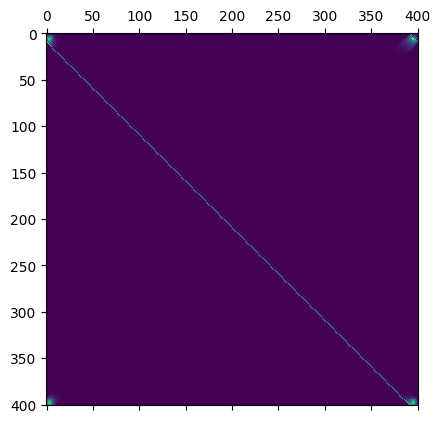

In [19]:
plt.matshow(np.abs(V_time))

In [10]:
(jnp.trace(U_is@jnp.conj(U_is).T)**2)/jnp.trace(U_is@jnp.conj(U_is).T@U_is@jnp.conj(U_is).T)

DeviceArray(1.224651-2.9779128e-09j, dtype=complex64)

# Tests to make SPDC in quadratures into quadratic equation

In [41]:
l = 1
inv_delta_t = 1
N_time = 401
min_time = -8
t = np.linspace(min_time, -min_time, N_time)
delta_t = np.abs(t[1] - t[0])
green_f = np.zeros((len(t), len(t)))

In [42]:
for i in range(len(green_f)):
    if i - (inv_delta_t/delta_t)*l > 0:
        green_f[i][int(i - (inv_delta_t/delta_t)*l)] = 1

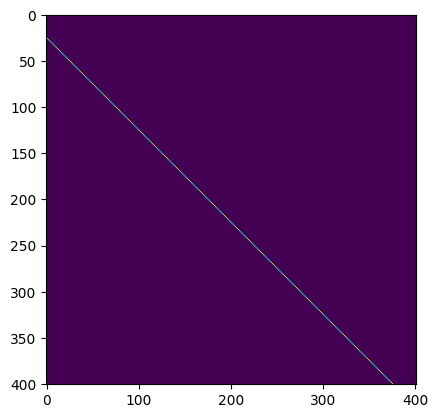

In [43]:
plt.imshow(green_f)